In [112]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import signal
import scipy.io as io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from os import path
from sklearn import metrics, svm, preprocessing, datasets, linear_model
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression


In [ ]:
# generamos un electrodo promedio por cada persona 
# (promediando los 5 electrodos del enunciado que se encuentran juntos)
# y los guardamos en disco. De esta manera a partir de ahora vamos a trabajar solo con esos archivos que son 
# mucho más livianos y tiene toda la información que necesitamos, 894 epochs por cada paciente.

electrodos_a_promediar = [7, 43, 79, 130, 184]

for t in ['P', 'S']:
    for i in range(1,11): 
        try:
            data_file = path.join('./data/',t) + "%02d" % (i) + '.mat'
            elec_prom_file = './dumps/elec_prom_' + t + "%02d" % (i) + '.dmp'
            data = io.loadmat(data_file)['data']
            electrodo_promedio = data[:,electrodos_a_promediar,:].mean(axis=1)
            electrodo_promedio.dump(elec_prom_file)
        except Exception as exception:
            print(str(exception))
            pass

In [ ]:
def calculate_welchs(data):
    welchs_by_epoch = np.empty((len(data),2,101))

    for i, epoch in enumerate(data):
        f,p = signal.welch(x=epoch, fs=250)
        welchs_by_epoch[i] = np.array([f,p])
    
    return welchs_by_epoch

In [ ]:

welchs = []

for i_type, t in enumerate(['P', 'S']):
    for i in range(1,11):
        try:
            file = './dumps/elec_prom_' + t + "%02d" % (i) + '.dmp'
            print(file)
            data = np.load(file)
            welchs.append(calculate_welchs(data)) 
            #print(data.shape)
            #print(repr(calculate_welchs(data)))
        except Exception as exception:
            print(str(exception))
            pass

In [ ]:
def calculate_epochs_power_mean(welchs_by_epoch, frequency_range):
    freqs = welchs_by_epoch[0,0,:]
    freqs_idxs = np.where((freqs>=frequency_range[0]) * (freqs<frequency_range[1]))
    return welchs_by_epoch[:,1,freqs_idxs].mean(axis=2)



frequencies_ranges = {"delta": (0,4), "theta": (4,8), "alpha": (8,13), "beta": (13,30), "gamma": (30,125)}
# matriz [paciente,banda_freq,epochs,potencia]

potencias_mean_std = np.zeros((20,5,2))
for i in range(20):
    for freq_idx,frequency_range in enumerate(frequencies_ranges.values()):
        frequency_epochs_power_means = calculate_epochs_power_mean(welchs[i],frequency_range)
        potencias_mean_std[i,freq_idx,0] = frequency_epochs_power_means.mean()
        potencias_mean_std[i,freq_idx,1] = frequency_epochs_power_means.std()

        #frequency_power_means.dump(name + 'power_means.dmp')

In [ ]:
column_names_mean = list(map(lambda x: x+"_mean",frequencies_ranges.keys()))
#df_mean = pd.DataFrame(potencias_mean_std[:,:,0],columns=column_names_mean)
df_mean = pd.DataFrame(preprocessing.scale(potencias_mean_std[:,:,0]),columns=column_names_mean)
column_names_std = list(map(lambda x: x+"_std",frequencies_ranges.keys()))
#df_std = pd.DataFrame(potencias_mean_std[:,:,1],columns=column_names_std)
df_std = pd.DataFrame(preprocessing.scale(potencias_mean_std[:,:,1]),columns=column_names_std)

labels = list([0]*10 + [1]*10)
df_labels = pd.DataFrame({"labels":labels})
tabla = pd.concat([df_mean,df_std,df_labels],axis=1)

tabla

In [ ]:
tabla['labels'].values

In [ ]:
def graficar_roc(table, values_column_name, labels_column_name,positivo):

    fpr, tpr, thresholds = metrics.roc_curve( \
        table[labels_column_name].values, \
        table[values_column_name].values, \
        pos_label=positivo, drop_intermediate=False)
   
    roc_auc = metrics.auc(fpr, tpr)
   
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
       

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {0}'.format(values_column_name))
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
for feature in (column_names_mean + column_names_std):
    graficar_roc(tabla,feature, 'labels', 0)


Logistic Regression

In [102]:
def calculate_Accuarcy(K_fold,save,diccionario):
    for feature in (column_names_mean + column_names_std):
        X = tabla.loc[:,feature].values.reshape(-1, 1)
        y = tabla.loc[:,'labels']
        clf = svm.SVC()
        scores = cross_val_score(clf, X,y, cv=K_fold)
        if save :
            diccionario[feature + '_Accuracy_mean'].append(scores.mean())
            diccionario[feature + '_Accuracy_std'].append(scores.std())
        else:
            print("Accuracy %s : %0.2f (+/- %0.2f)" % (feature,scores.mean(), scores.std() * 2))

def calculate_Accuarcy_All(K_fold,save,diccionario):
    # X son todas los features con sus respectivos valores para cada sample
    X = tabla.iloc[:,:-1]
    # Y son todos los labels de los samples, representados como 0 si es un paciente P y 1 si es un paciente de tipo S
    y = tabla.loc[:,'labels']
    # print(Y)
    clf = svm.SVC()
    scores = cross_val_score(clf, X,y, cv=K_fold)
    if save :
        diccionario['All_Features_Accuracy_mean'].append(scores.mean())
        diccionario['All_Features_Accuracy_std'].append(scores.std())
    else:
        # El score promedio y el intervalo de confianza con 95% del score estimado
        print("Accuracy %s: %0.2f (+/- %0.2f)" % ('con todos los features',scores.mean(), scores.std() * 2))


def new_dict():
    di = dict()
    di['All_Features_Accuracy_mean'] = []
    di['All_Features_Accuracy_std'] = []
    for feature in (column_names_mean + column_names_std):
            di[feature + '_Accuracy_mean'] = []
            di[feature + '_Accuracy_std'] = []
    return di

def plot_mean_and_std(feature,means,stds):
    x = np.arange(2,10)
    y = means
    e = stds

    plt.errorbar(x, y, e, linestyle='None', marker='^', ecolor='orange', uplims=True, lolims=True)
    plt.xlabel('K_Fold')
    plt.ylabel('Accuarcy')
    plt.title(feature)

    plt.show()

In [105]:
calculate_Accuarcy(3,False,{})

calculate_Accuarcy_All(3,False,{})

Accuracy delta_mean : 0.89 (+/- 0.16)
Accuracy theta_mean : 0.75 (+/- 0.14)
Accuracy alpha_mean : 0.79 (+/- 0.18)
Accuracy beta_mean : 0.74 (+/- 0.20)
Accuracy gamma_mean : 0.65 (+/- 0.04)
Accuracy delta_std : 0.78 (+/- 0.31)
Accuracy theta_std : 0.71 (+/- 0.18)
Accuracy alpha_std : 0.75 (+/- 0.14)
Accuracy beta_std : 0.60 (+/- 0.14)
Accuracy gamma_std : 0.42 (+/- 0.24)
Accuracy con todos los features: 0.94 (+/- 0.16)


Veamos como varia la presicion en función de los K_Folds utilizados

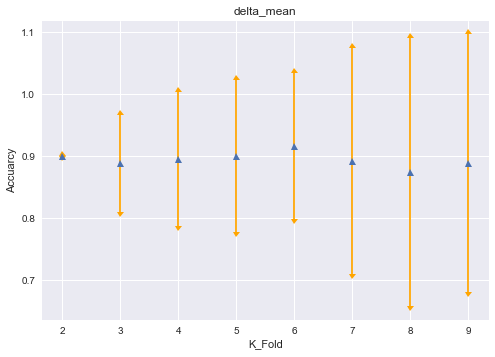

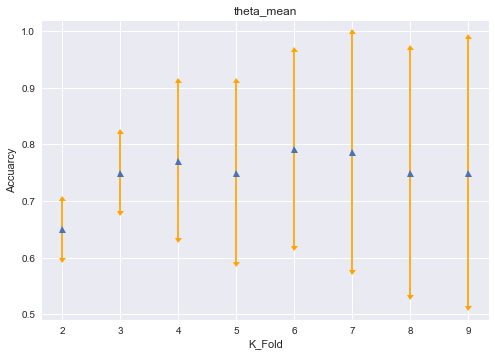

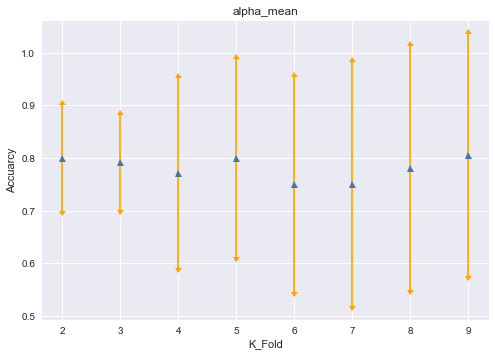

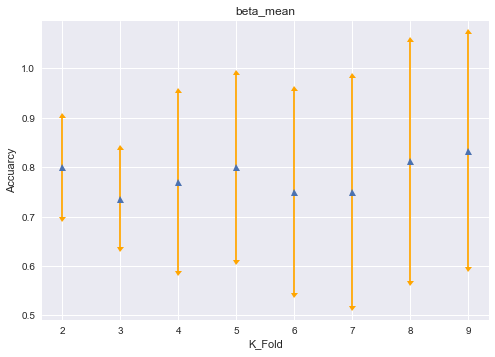

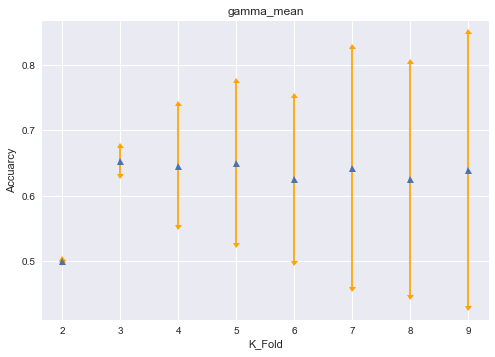

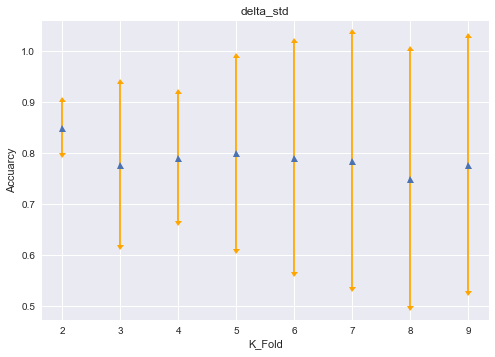

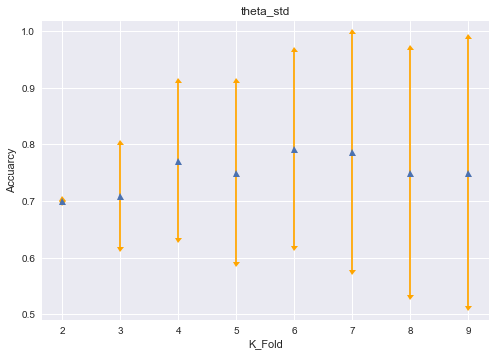

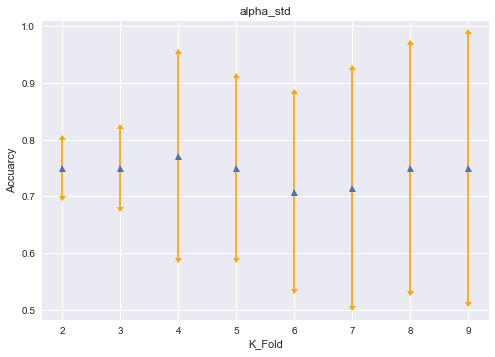

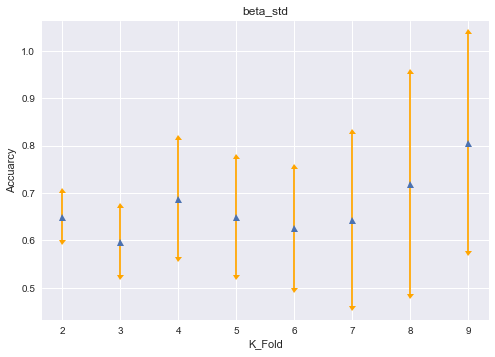

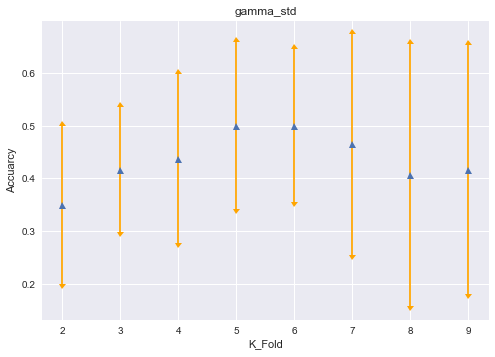

In [110]:
Accuarcy_dict = new_dict()

for i in range(2,10):
    calculate_Accuarcy(i,True,Accuarcy_dict)
    calculate_Accuarcy_All(i,True,Accuarcy_dict)
    
for feature in (column_names_mean + column_names_std):
    plot_mean_and_std(feature,Accuarcy_dict[feature + '_Accuracy_mean'],Accuarcy_dict[feature + '_Accuracy_std'])


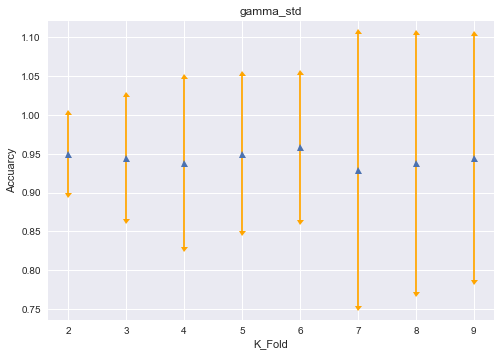

In [111]:
plot_mean_and_std(feature,Accuarcy_dict['All_Features_Accuracy_mean'],Accuarcy_dict['All_Features_Accuracy_std'])

Support Vector Machine

In [121]:


X = tabla.iloc[:,:-1]

y = tabla.loc[:,'labels']
# ANOVA SVM-C


anova_filter = SelectKBest(f_regression, k=2)
clf = svm.SVC(kernel='linear')
anova_svm = Pipeline([('anova', anova_filter), ('svc', clf)])

anova_svm.fit(X, y)
                     



prediction = anova_svm.predict(X)
anova_svm.score(X, y)                        

# getting the selected features chosen by anova_filter
#anova_svm.named_steps['anova'].get_support()

# Another way to get selected features chosen by anova_filter
#anova_svm.named_steps.anova.get_support()


0.90000000000000002